# LightGBM案例

## 思路
1. 提取有用的历史数据，不同周期
2. 使用未来一周或者一定时间的收益率情况来进行训练
3. 预测未来的市场走势，尝试进行非对称的训练，如上涨2%视为一类，达不到上涨2%视为另一类

注意：
如果所有的数据都来自于价量指标，是否会存在Correlation和过拟合的风险


In [1]:
# import 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # statistical data visualization

In [2]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
import matplotlib.pyplot as plt

# plt的默认设置
plt.rcParams['figure.figsize'] = [18.0, 10.0]  # 宽度, 高度

plt.rcParams['axes.spines.right']= False
plt.rcParams['axes.spines.top']= False
plt.rcParams['axes.spines.left']= False
plt.rcParams['axes.spines.bottom']=False

plt.rcParams['axes.labelsize'] = 14  # 设置坐标轴标签字体大小
plt.rcParams['axes.titlesize'] = 16  # 设置标题字体大小
plt.rcParams['xtick.labelsize'] = 12  # 设置x轴刻度标签字体大小
plt.rcParams['ytick.labelsize'] = 12  # 设置y轴刻度标签字体大小
plt.rcParams['grid.alpha'] = 1  # 设置网格透明度

plt.rcParams['axes.grid'] = True # 设置网格线

plt.rcParams['legend.fontsize'] = 16 

plt.rcParams['font.family'] = "monospace" # 设置图片字体

## 1. 准备训练数据

In [4]:
# 选择沪深300ETF进行跟踪
candidate_ETF = "159919.XSHE"

# 确定整体时间长度，默认设置为过去1000天
ncount = 1500

# 确定end_date
end_date='2025-01-27'


In [5]:
# 生成价格pandas数组
price_pd = pd.DataFrame()

price_pd = get_price(candidate_ETF, count = ncount, end_date=end_date, frequency='daily', fields=['close','volume'])

price_pd.columns = ['price', 'volume']

In [6]:
price_pd.head()

,price,volume
2018-11-23,2.948,37777493.0
2018-11-26,2.938,44255842.0
2018-11-27,2.941,9422309.0
2018-11-28,2.980,19097891.0
2018-11-29,2.952,14413113.0



### 对提取的数据进行处理

原理：
1. 1日收益率、5日收益率、30日收益率进行
2. 1日成交量增长率、5日成交量增长率、30日成交量增长率
3. 过去20日的收益波动水平
4. 通过观测数据推测market state

波动率的公式：
$\sigma = \sqrt{\frac{250}{n-1} \sum_{i=1}^{n} (r_{p_i} - \bar{r}_p)^2}$

说明：n选择为20

In [7]:
# 对数据进行处理
# 生成收益率数据
price_pd['1d_yield'] = price_pd['price']/price_pd['price'].shift(1)
price_pd['5d_yield'] = price_pd['price']/price_pd['price'].shift(5)
price_pd['30d_yield'] = price_pd['price']/price_pd['price'].shift(30)

# 生成成交量数据
price_pd['1d_volume_change'] = price_pd['volume']/price_pd['volume'].shift(1)
price_pd['5d_volume_change'] = price_pd['volume']/price_pd['volume'].shift(5)
price_pd['30d__volume_change'] = price_pd['volume']/price_pd['volume'].shift(30)


# 生成波动率数据
# 生成rolling average数据
rolling_window = 20

price_pd['std'] = price_pd['price'].rolling(window=rolling_window).std()

In [8]:
price_pd.head()

,price,volume,1d_yield,5d_yield,30d_yield,1d_volume_change,5d_volume_change,30d__volume_change,std
2018-11-23,2.948,37777493.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-11-26,2.938,44255842.0,0.996608,NaN,NaN,1.171487,NaN,NaN,NaN
2018-11-27,2.941,9422309.0,1.001021,NaN,NaN,0.212905,NaN,NaN,NaN
2018-11-28,2.980,19097891.0,1.013261,NaN,NaN,2.026880,NaN,NaN,NaN
2018-11-29,2.952,14413113.0,0.990604,NaN,NaN,0.754697,NaN,NaN,NaN


### 增加因子数据


数据来自聚宽因子库：https://www.joinquant.com/help/api/help#name:factor_values

因子如下：
1. leverage因子：0.38•market_leverage + 0.35•debt_to_assets + 0.27•book_leverage
2. liquidity因子：0.35•share_turnover_monthly + 0.35•average_share_turnover_quarterly + 0.3•average_share_turnover_annual
3. book_to_price_ratio因子：最新一季财报的账面价值与当前市值的比值（pb_ratio的倒数）。其中小于0的值设置为nan
4. operating_revenue_growth_rate：收入增长率
5. net_asset_growth_rate：净资产增长率
5. PEG


In [9]:
# 导入函数库
from jqfactor import get_factor_values


factor_list = ['leverage','liquidity','book_to_price_ratio',
               'operating_revenue_growth_rate',
               'net_asset_growth_rate',
               'PEG']

# 获取因子
# 因为数据的原因，所以获取上证指数“000001”作为参数
factor_data = get_factor_values(securities=['000001.XSHE'], factors=factor_list, 
                                count = ncount, end_date=end_date )


In [10]:
for factor_i in factor_list:
    print(factor_i)
    price_pd = pd.concat([price_pd,factor_data[factor_i]],axis = 1)
    
    
    # 重命名相应的列
    price_pd = price_pd.rename(columns={'000001.XSHE':factor_i})

leverage
liquidity
book_to_price_ratio
operating_revenue_growth_rate
net_asset_growth_rate
PEG


In [11]:
# 截取后面有效的数据，前面的Nan数据删除
factor_data_pd = price_pd.iloc[30:,:]

# 对factor_data中的NA值进行处理
factor_data_pd = factor_data_pd.fillna(0)

In [12]:
factor_data_pd.tail()

,price,volume,1d_yield,5d_yield,30d_yield,1d_volume_change,5d_volume_change,30d__volume_change,std,leverage,liquidity,book_to_price_ratio,operating_revenue_growth_rate,net_asset_growth_rate,PEG
2025-01-21,4.020,127838496.0,1.001245,1.003495,0.966811,0.937738,0.540851,0.482994,0.096681,1.851702,-0.170828,2.681725,-0.121804,0.052825,0.0
2025-01-22,3.983,196344531.0,0.990796,1.000502,0.951278,1.535880,1.772404,0.524555,0.091438,1.855890,-0.173311,2.694540,-0.121804,0.052825,0.0
2025-01-23,3.991,186677880.0,1.002009,1.001757,0.954785,0.950767,1.079157,0.675302,0.084594,1.843232,-0.152568,2.680530,-0.121804,0.052825,0.0
2025-01-24,4.027,210284858.0,1.009020,1.006750,0.954265,1.126458,1.291107,0.660351,0.075423,1.847357,-0.177102,2.695121,-0.121804,0.052825,0.0
2025-01-27,4.006,301618459.0,0.994785,0.997758,0.972330,1.434333,2.212473,0.598814,0.064030,1.838796,-0.138959,2.698175,-0.121804,0.052825,0.0


## 2. 生成判断

根据当前的日期，生成结果数据

**结果判断依据**：未来一周是否上涨超过1%

In [13]:
result_pd = pd.concat([price_pd['price'],price_pd['price'].shift(-10)],axis=1)
result_pd.columns = ['price','future_price']

result_pd['yield'] = result_pd['future_price']/result_pd['price'] -1

result_pd['result'] = np.array(result_pd['yield'] > 0.01)

In [14]:
# 要与factor_data_pd对齐数据

result_pd = result_pd.loc[list(factor_data_pd.index)]

## 3. 使用LightGBM


In [15]:
# 需要保留最后一行数据，作为预测用

X = factor_data_pd.iloc[:-5,2:]
y = result_pd['result'][:-5]

X_sample = factor_data_pd.iloc[-5:,2:]

In [16]:
X_sample

,1d_yield,5d_yield,30d_yield,1d_volume_change,5d_volume_change,30d__volume_change,std,leverage,liquidity,book_to_price_ratio,operating_revenue_growth_rate,net_asset_growth_rate,PEG
2025-01-21,1.001245,1.003495,0.966811,0.937738,0.540851,0.482994,0.096681,1.851702,-0.170828,2.681725,-0.121804,0.052825,0.0
2025-01-22,0.990796,1.000502,0.951278,1.535880,1.772404,0.524555,0.091438,1.855890,-0.173311,2.694540,-0.121804,0.052825,0.0
2025-01-23,1.002009,1.001757,0.954785,0.950767,1.079157,0.675302,0.084594,1.843232,-0.152568,2.680530,-0.121804,0.052825,0.0
2025-01-24,1.009020,1.006750,0.954265,1.126458,1.291107,0.660351,0.075423,1.847357,-0.177102,2.695121,-0.121804,0.052825,0.0
2025-01-27,0.994785,0.997758,0.972330,1.434333,2.212473,0.598814,0.064030,1.838796,-0.138959,2.698175,-0.121804,0.052825,0.0


In [17]:
# split the dataset into the training set and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [18]:
# build the lightgbm model
import lightgbm as lgb
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [19]:
# predict the results
y_pred=clf.predict(X_test)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [20]:
# view accuracy
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

LightGBM Model accuracy score: 0.7886


In [21]:
y_pred_train = clf.predict(X_train)
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))


Training-set accuracy score: 1.0000


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [22]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(clf.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(clf.score(X_test, y_test)))

Training set score: 1.0000
Test set score: 0.7886


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [23]:
# view confusion-matrix
# Print the Confusion Matrix and slice it into four pieces

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[240 32]
 [61 107]]

True Positives(TP) =  240

True Negatives(TN) =  107

False Positives(FP) =  32

False Negatives(FN) =  61


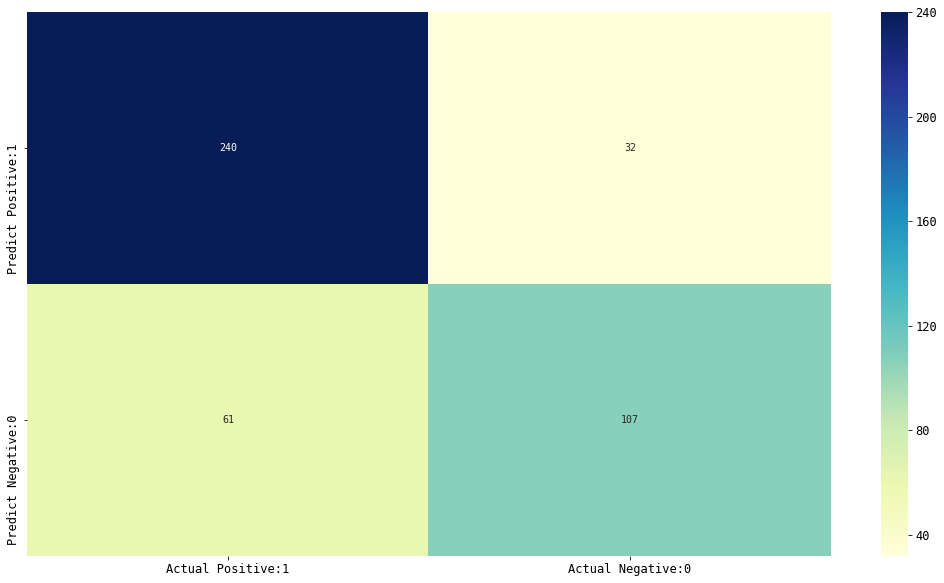

In [24]:
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

      False       0.80      0.88      0.84       272
       True       0.77      0.64      0.70       168

avg / total       0.79      0.79      0.78       440



## 4. 进行预测

In [26]:
y_sample = clf.predict(X_sample)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [27]:
y_sample

array([False, False, False, False, False])

In [28]:
X_sample.index

DatetimeIndex(['2025-01-21', '2025-01-22', '2025-01-23', '2025-01-24',
               '2025-01-27'],
              dtype='datetime64[ns]', freq=None)